In [ ]:
!pip install --upgrade openai pandas scikit-learn numpy

^C
ERROR: Operation cancelled by user


In [ ]:
import json
import openai
import numpy as np
import pandas as pd
openai.api_key = ''


**To solve this task I have taken the following approach, Firstly I have performed basic analysis to show that there are some patterns in the data and how they affect user acceptance. Next I have designed a much better approach to understand what matters most for a user when he is evaluating text. I have found 4 metrics in this regard and I call them langauge metrics. Then I show that these metrics are useful in showing which model outputs pass. After that I have trained models to predict these metrics, these models also serve to find problematic behaviour or can be used for evaluation/improvement**

**Load the Dataset into a Json File and perform some basic analysis around the features and data**

In [ ]:
dataset = json.load(open('final_mle_dataset.json'))

In [ ]:
dataset[3].keys()

dict_keys(['product_name', 'product_description', 'prospect_name', 'prospect_industry', 'prospect_title', 'email', 'accepted', 'critique', 'edited', 'email_embedding', 'edited_embedding'])

In [ ]:
len(dataset[3]['email_embedding'])

1536

**Create a version of the dataset with no embeddings for easier viewing and analysis**

In [ ]:
dataset_no_embeddings = []
for item in dataset:
    copy = item.copy()
    del copy['email_embedding']
    del copy['edited_embedding']
    dataset_no_embeddings.append(copy)


In [ ]:
dataset_no_embeddings[1]

{'product_name': 'Wireless Earbuds',
 'product_description': 'Sleek and comfortable earbuds with noise-cancellation and long battery life.',
 'prospect_name': 'David Lee',
 'prospect_industry': 'Finance',
 'prospect_title': 'Financial Analyst',
 'email': "\nHello David,\n\nI hope you are doing well! I'm a chatbot and I was wondering if you might be interested in purchasing a new set of wireless earbuds. They're sleek and comfortable and come with noise-cancellation and long battery life. I think you would really enjoy them, and I'm sure your colleagues would appreciate the peace and quiet they provide. I would be happy to give you more information about the product.\n\nIf you have any questions, please don't hesitate to reach out. I look forward to hearing from you soon.\n\nSincerely,\n\nYour chatbot",
 'accepted': False,
 'critique': "The email lacks a human touch and seems spammy. The opening line 'I'm a chatbot' can put off the prospect. Additionally, there's no mention of how the p

In [ ]:
json.dump(dataset_no_embeddings,open('out.json','w'))

**Convert the no embedding version into a dataframe**

In [ ]:
dataset_df = pd.DataFrame.from_dict(dataset_no_embeddings)

In [ ]:
dataset_df.to_csv('out.csv')

**I do some analysis around what kind of data gets accepted and what features are prominent with user acceptance**

In [ ]:
dataset_df['accepted'].value_counts().head()

True     524
False    493
Name: accepted, dtype: int64

In [ ]:
dataset_df['generation_length']=dataset_df['email'].apply(lambda x:len(x.split(" ")))
dataset_df['desc_length'] = dataset_df['product_description'].apply(lambda x:len(x.split(" ")))

In [ ]:
accept = dataset_df[dataset_df['accepted']==True]
reject = dataset_df[dataset_df['accepted']==False]

In [ ]:
accept['prospect_industry'].value_counts().nlargest(10)

Healthcare       42
Education        33
Entertainment    28
Finance          27
Technology       26
Fitness          20
Security         19
Food             19
Energy           16
Marketing        15
Name: prospect_industry, dtype: int64

In [ ]:
reject['prospect_industry'].value_counts().nlargest(10)

Healthcare           61
Technology           30
Education            25
Finance              25
Hospitality          23
Security             21
Food and Beverage    19
None                 18
Food                 17
Marketing            17
Name: prospect_industry, dtype: int64

In [ ]:
accept['product_name'].value_counts().nlargest(10)

Smart Thermostat           23
Home Security System       20
Smart Lock                 18
Smart Scale                17
Virtual Reality Headset    16
Electric Car               15
Fitness Equipment          15
Pet Food                   12
Art Supplies               11
Smart Water Bottle         11
Name: product_name, dtype: int64

In [ ]:
reject['product_name'].value_counts().nlargest(10)

Fitness Tracker         21
Smart Lock              19
Baby Products           19
Smart Thermostat        18
Smart Speaker           17
Outdoor Gear            15
Kitchen Appliances      12
Fitness Equipment       12
Smart Refrigerator      11
Home Security System    11
Name: product_name, dtype: int64

In [ ]:
print(" generation length for accpeted ", accept['generation_length'].mean(), " generation length for rejected ",reject['generation_length'].mean())

 generation length for accpeted  96.15458015267176  generation length for rejected  100.08316430020284


In [ ]:
print(" product desc length for accpeted ", accept['desc_length'].mean(), " product desc length for rejected ",reject['desc_length'].mean())

 product desc length for accpeted  10.223282442748092  product desc length for rejected  10.117647058823529


In The above analysis we observe that there are some patterns in which products are more likely to be rejected by users, one could say that something like a fitness tracker is more likely to be rejected as we see its the top rejected product or prospects from healthcare are also much more likely to reject a generated email. We can try to find more patterns around mentions of which word in the description or title can lead to a rejection. Using these features we could learn to classify a piece of text as that would be accepted or rejected. That model could then provide insights on what features work and which features dont work. This is one direction to take the analysis further however I believe there is a completely different reason to why some generated texts get rejected and when they dont get rejected.

**Second type of Analysis**

I believe its important to observe that the user has provided critique on why the text gets rejectd, explaining thier reasons. In my opinion we can develop a much more generalizable approach when we look at the critique and try to find problems with the text rather than focusing on impact of certain product names or keywords on the user acceptance. Lets say in future we get a user who wants to generate short descriptions for a book given its prologue. For this user it wouldnt make sense to look specific features like product names etc. To summarize, an approach to find why a prompt/model output fails should extend beyond analysis around specific keywords.

When we want to learn why a model output has failed we want to look at the language and if the generated text has fullfilled the users expectation, since for this dataset we have the user critique we can use that for this analysis. After going through a number of data points we can see that the user thinks that the generated text is bad when it doesnt meet one of the following criteria. I also like to call these langauge metrics.

1. conciseness
2. language quality/Grammar
3. empathy
4. personalized/Relevance

From my qualitative analysis we can see that user wants the text to be really concise and easy to read, the text should be clear in what it wants to convey. Secondly, the user wants the LLM to generate text that is of high quality and that has no errors. Next, the from the critique's really cares about how emapthetic is the text, they want the generated text to strike a connection with the reader, the text should be comforting and friendly. Finally, the user cares about how personalized the text is. They dont want the readers to think that this is some template text.

From the user responses I have found these metrics to be crucial to the user and whenever the text doesnt meet this criteria, the user points it out and rejects the text. But we have a problem here, even though these metrics are encoded in user's response there is no easy way to extract it from the text. One way would be to label the data manually but since I didnt have time for that I have used gpt-3.5-turbo to find the numeric labels from the critique by using this prompt below.



**prompting gpt to find the labels around language features like empathy etc**

In [ ]:
def generate_prompt(text,critique):
    prompt = f"""You have recieved a piece of text generated by a LLM ('text') and there is critique for that text provided as well ('critique'), your job is to now rate it based on the criteria using the text and its critique:

1. conciseness
2. language quality/Grammar
3. empathy
4. personalized/Relevance

Give a rating in the range of 0-1 depending how much the text fullfills the criteria . Also respond only with the ratings for each provided text and critique as metric:rating.

  'TEXT': {text}
 'critique': {critique}
"""
    return prompt

def call_openai(prompt):
    MODEL = "gpt-3.5-turbo"
    response = openai.ChatCompletion.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": prompt},
        ],
        temperature=0,
    )

    return response['choices'][0]['message']['content']





# file = json.load(open('out.json','r'))
# output = []
# for idx,item in tqdm(enumerate(file),total=1017):
#     text = item['email']
#     critique = item['critique']
#     if critique=='':
#         continue
#     prompt = generate_prompt(text,critique)
#     labels = call_openai(prompt)
#     item['labels']=labels
#     output.append(item)
#     json.dump(output,open('final_2.json','w'))


I experimented with a number of prompts and outputs for GPT and then finalized on this one. In my experimentations I saw that GPT does better when I ask it generate ratings with the name of the metric and it does alot better when it can pick values in the range of 0-1. Furthermore I also experimented with if it should generate explainations or chain of thought prompting but due to lack of time I settled on this approach. I have made available the output jsons from GPT with the labels.

In [ ]:
"""Processing the new labels from GPT's output"""
def process_label(text):
    components = text.split("\n")
    out= {}
    for it in components[:4]:
        f= it.split(" ")
        metric = f[0]
        score = f[-1]
        out[metric]= float(score)
    return out


generated_dataset_1 = json.load(open('final.json','r'))
generated_dataset_2 = json.load(open('final_2.json','r'))

generated_dataset=[]
generated_dataset.extend(generated_dataset_1)
generated_dataset.extend(generated_dataset_2)


for data_point in generated_dataset:
    gen_data = data_point['labels']
    scores = process_label(gen_data)
    data_point.update(scores)
    del data_point['labels']

generated_df = pd.DataFrame.from_dict(generated_dataset)




In [ ]:
dataset_embeddings = []
for item in dataset:
    if item['critique']=='':
        continue
    dataset_embeddings.append(item)


In [ ]:
embeddings = [item['email_embedding'] for item in dataset_embeddings]

In [ ]:
generated_df['embeddings']=embeddings

In [ ]:
generated_df

,product_name,product_description,prospect_name,prospect_industry,prospect_title,email,accepted,critique,edited,conciseness:,language,empathy:,personalized/Relevance:,embeddings
0,Fitness Tracker,A wearable device that tracks your daily activ...,Emily Nguyen,Healthcare,Nurse Practitioner,"\nHello Emily,\n\nThank you for your email! I ...",False,The email does not address Emily's needs. It a...,"Hello Emily,\n\nI was thrilled to receive your...",1.0,1.0,0.2,0.30,"[-0.0205299723893404, 0.010440289042890072, 0...."
1,Wireless Earbuds,Sleek and comfortable earbuds with noise-cance...,David Lee,Finance,Financial Analyst,"\nHello David,\n\nI hope you are doing well! I...",False,The email lacks a human touch and seems spammy...,"Hello David,\n\nI hope this email finds you we...",1.0,1.0,0.2,0.20,"[-0.02587042935192585, 0.008525044657289982, -..."
2,Smart Thermostat,A thermostat that learns your preferred temper...,Sarah Kim,Education,Teacher,"\nHello Sarah,\n\nThank you for reaching out t...",False,The email fails to provide any information tha...,"Hi Sarah, Thank you for showing interest in ou...",1.0,1.0,0.0,0.00,"[-0.01127349678426981, -0.0051771956495940685,..."
3,Smart Lock,A keyless lock that can be controlled remotely...,Michael Brown,Security,Security Officer,"\nHello Michael,\n\nI hope this email finds yo...",False,The email is too formal and robotic. It doesn'...,"Hi Michael,\n\nI hope this email finds you wel...",0.8,0.9,0.2,0.30,"[-0.016323497518897057, -0.01875770278275013, ..."
4,Wireless Charger,A convenient wireless charger that can charge ...,Karen Wilson,Marketing,Marketing Manager,"\nHello Karen,\n\nThank you for considering ou...",False,The email does not provide any relevant inform...,"Hello Karen,\n\nAs a Marketing Manager, we und...",0.8,0.9,0.5,0.20,"[-0.00021778080554213375, 0.008959198370575905..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,Personal Care Products,Natural and organic personal care products for...,Katie Johnson,Healthcare,Nurse,"\nHello Katie Johnson,\n\nThank you for your i...",True,"The email is well-written, concise and relevan...","Hello Katie Johnson,\n\nThank you for your int...",1.0,1.0,0.5,0.50,"[0.014148660935461521, 0.015647681429982185, -..."
862,Electronic Gadgets,The latest and greatest electronic gadgets for...,David Brown,Technology,Software Engineer,"\nHi David,\n\nHope you're doing well! I'm a c...",False,The email feels too generic and lacks empathy ...,"Dear David,\n\nI hope this email finds you wel...",0.8,0.9,0.2,0.30,"[-0.027653204277157784, 0.013073998503386974, ..."
863,Jewelry,Stunning and unique jewelry for any occasion.,Sophia Davis,Retail,Sales Associate,"\nDear Sophia,\n\nThank you for taking the tim...",False,The email lacks personalization and does not s...,"Hello Sophia,\n\nThank you for your inquiry. I...",1.0,1.0,0.0,0.20,"[-0.008785529062151909, -0.0050754239782691, 0..."
864,Organic Food,Fresh and organic food for health-conscious co...,William Johnson,Food and Beverage,Restaurant Chef,"\nHello William Johnson,\n\nThank you for your...",False,The email is too generic and lacks any persona...,"Dear William Johnson,\n\nAs a restaurant chef ...",1.0,1.0,0.5,0.25,"[0.011533858254551888, -0.01323461439460516, -..."


We will do some analysis to see how the new labels correlate with the acceptance feature.

In [ ]:
accept_df = generated_df[generated_df['accepted']==True]
reject_df = generated_df[generated_df['accepted']==False]

In [ ]:
print("average conciseness in accepted ",accept_df['conciseness:'].mean()," average conciseness in rejected ",reject_df['conciseness:'].mean())

average conciseness in accepted  0.9402144772117964  average conciseness in rejected  0.8503042596348885


In [ ]:
print("average quality in accepted ",accept_df['language'].mean()," average quality in rejected ",reject_df['language'].mean())

average quality in accepted  0.9552278820375335  average quality in rejected  0.9036511156186614


In [ ]:
print("average empathy in accepted ",accept_df['empathy:'].mean()," average empathy in rejected ",reject_df['empathy:'].mean())

average empathy in accepted  0.6225201072386058  average empathy in rejected  0.22920892494929007


In [ ]:
print("average relevance in accepted ",accept_df['personalized/Relevance:'].mean()," average relevance in rejected ",reject_df['personalized/Relevance:'].mean())

average relevance in accepted  0.6986595174262735  average relevance in rejected  0.27038539553752533


In the above analysis we see that there is higher acceptance with higher empathy and higher personalization, we also see that accepted texts have slightly higher conciseness and higher quality of language. I beleive these are the features we should use to understand which outputs fail and which dont. These features can be extended to any kind of generated text and they can be generalized to other prompts as well. These features set the foundation of what makes a LLM generated text useful to a user.

In [ ]:
"""To further Drive the point home to show the importance of the features we can use them to predict the acceptance of a user"""

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test= train_test_split(generated_df, test_size=0.20)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
accepted_model = XGBClassifier()
accepted_model.fit(X_train[['conciseness:','language','empathy:','personalized/Relevance:']],X_train['accepted'].astype(int))
yhat = accepted_model.predict(X_test[['conciseness:','language','empathy:','personalized/Relevance:']])
print(classification_report(X_test['accepted'].astype(int),yhat))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       105
           1       0.96      0.96      0.96        69

    accuracy                           0.97       174
   macro avg       0.96      0.96      0.96       174
weighted avg       0.97      0.97      0.97       174



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

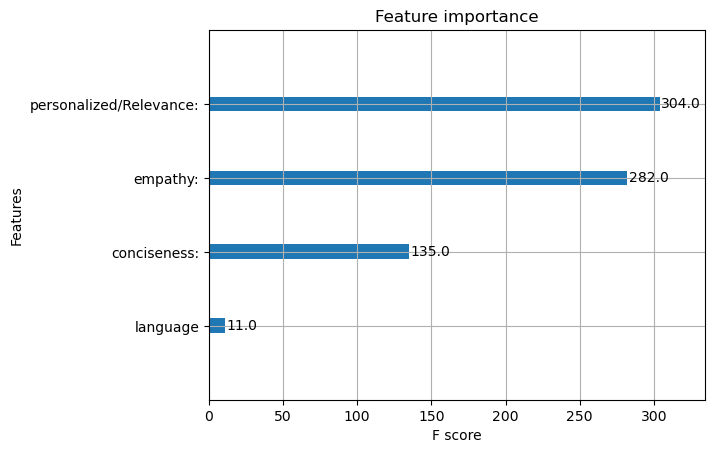

In [ ]:
from xgboost import plot_importance

plot_importance(accepted_model)


In the above results and the plot we see that firstly the model does quite well on the task and these features are a good indicator of acceptance, which is good for us. Secondly from the feature importance graph we learn something interesting, we can observe that model believes that personalization is the most important feature so if a piece of text is personalized towards the reader, it has a higher chance of passing. Second most important feature happens to be emapthy and how empathetic is the text, so this is also helpful, because if you want a user to like the text it should be empathetic. Apart from these two conciseness matters but not as much. Finally we observe that language quality matters quite less, but I believe this is an issue as most of generated outputs have good quality and if we did have low quality texts, this feature would matter just as much.

Now we have learnt when an output will fail but what if want to analyze the model outputs? We wont always have critique available to us. To solve this problem we can learn regression models that predict the language metrics. Using the labelled data generated above we can learn a model to do this task for us. This model can be used in future without any critique to predict the empathy, relevance etc of any text. So by these models we can analyze model outputs for problematic behaviours. Furthermore as we will see below these models can be used to improve the prompt and the model as they carry the information of human alignment. These language metric predictors are actually similar to reward models.

**train language metric predictors**

In [ ]:
train_data = [i for i in X_train['embeddings'].values]
test_data = [i for i in X_test['embeddings'].values]
train_data = np.vstack(train_data)
test_data = np.vstack(test_data)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

empathy_model = XGBRegressor()
empathy_model.fit(train_data, X_train['conciseness:'])
yhat = empathy_model.predict(test_data)
print("MSE ",mean_squared_error(X_test['conciseness:'].values, yhat))

MSE  0.01936733509396409


In [ ]:
empathy_model = MLPRegressor(random_state=1, max_iter=500)
empathy_model.fit(train_data, X_train['language'])
yhat = empathy_model.predict(test_data)
print("MSE ",mean_squared_error(X_test['language'].values, yhat))

MSE  0.008814938775283788


In [ ]:
empathy_model = MLPRegressor(random_state=1, max_iter=500)
empathy_model.fit(train_data, X_train['empathy:'])
yhat = empathy_model.predict(test_data)
print("MSE ",mean_squared_error(X_test['empathy:'].values, yhat))

MSE  0.09845080062169546


In [ ]:
empathy_model.fit(train_data, X_train['personalized/Relevance:'])
yhat = empathy_model.predict(test_data)
print("MSE ",mean_squared_error(X_test['personalized/Relevance:'].values, yhat))

MSE  0.0983875359826605


I have trained one model for every predictor, however from the early results they are fairly average in performance. I suspect that these models are not doing a very good job of predicting these features because there is not enough data available to use, right now the email embedding is 1536 but we only have 1017 ( 866 due to some having no critiques) samples. If we have more data I am confident that we can train better and more performant models to predict langauge metrics from the embeddings.

If I assume in future we are successfull in training these models that capture human alignment and can rate each text for its empathy, etc. Then we can use them to find model outputs with problematic behaviours. As we saw above its super important that a text meets these metrics and our models will do just that for us.

To quickly summarize the analysis until now

1. Provide a topic analysis on what kinds of inputs and outputs the prompt template fails on

For this analysis I have shown that rather than using specific keywords we should follow specific language metrics. This can include things like empathy etc, we show that these language metrics are good at understanding acceptance. We can also see which of these language metrics are most important according to a trained xgboost model, so using this analysis we can see where and why each output failed and how it didnt meet the metric.


2. Analyze the model outputs for problematic behaviors

To do this we again rely on the concept of languag metrics but now I have trained specific regression models that capture these metrics and try to predict them. These would come in handy when you have no critique but want to see how the model performs on certain language metrics furthermore for a new text we can generate langauge metrics and then use them in the earlier trained xgboost model to predict user acceptance. That makes these models quite useful in telling us how much a user would like a new piece of generated text. If we get a new model output we can rate it on our langauge metrics easily.

I'all answer these questions below

3. Suggest improvements to the original prompt template
4. Suggest evaluation criteria to compare prompt templates

3. Suggest improvements to the original prompt template

>1.Initially looking at the model outputs we can tell that there are some obvious flaws, alot of the model outputs sound robotic and have not been written from the behalf of a human and readers dont like this. A simple hack would be to tell the model to write as a human who is empathetic and wants to build a personal connection. If we tell the LLM to write the text in a certain way it can follow that as well. So we can add mentions that we want the text to be empathetic and the tone should be very friendly. There might be some experimentations required on how this information should be added. Furthermore, we should tell it that the text should form a connection with the user. Overall, adding more context and detail is always helpful to the LLM. Finally a good tip is to add demonstrations, in the original prompt we can first simulate a conversation and show the LLM how to respond to these kind of questions, LLMs have been shown to perform few shot in context learning well, so adding demonstrations is helpful. Finally we can look at prompt and think if there is any tokenization issue in the prompt, any issues like that can change the meaning of the word to the LLM. We can experiment with methods that improve prompts through users output next.

>2.lets now think around how we can improve a prompt template given we have critique from the user. We can use LLMs themselves to improve a prompt. We can use a simple prompt like this to edit a prompt

prompt = """ Assume you are a person who is guiding a large language model to become better. you have been provided a prompt that was used to generate a output, On the given output there is also feedback on how the large language model can do better. Now your job is to take this feedback and make edits or additions in the original prompt so that when the large language model generates some new text, it resolves all shortcomings from the feedback

prompt={}
generated_text={}
feedback={}

Respond with the edited prompt that you think incorporates feedback well. """

> 3.This is a very basic example of what that prompt would look like, however we can use more advanced versions as well and experiment alot. Now it may be the case that you dont always have user feedback and you still want to improve the prompts. We can use the langauge metric predictors here! So lets say for a model output we get predictions, now we can provide those in a prompt in a way like " an external method has rated the output on the X metric with this score Z, make improvements to the prompt so that we can get a better score on the metric"

>4.Finally we can also use recent research RL based methods like https://arxiv.org/abs/2305.03495, these methods use a metric and then use beam search to search for a prompt that can optimize the metrics. For us we can use the language metric predictors in this scenario. If we can use self deployed LLMs we can also use methods like soft prompts to edit a prompt, this method performs gradient descent on the prompt to change it so that it does better on a metric.



4. Suggest evaluation criteria to compare prompt templates

> 1.When we are comparing prompt templates we can look at thier model generations to asses thier performance. We can use simple methods like METEOR, BLEU that match synonyms, ngrams etc to generate a score. However there is generally less correlation of these methods with actual human evaluation. Because of these reasons people have resorted to using LLMs themselves to rate text. A method like this https://arxiv.org/abs/2303.16634 uses chain of thought reasoning to evaluate a prompts output using GPT4. In this papaer they ask the model to generate evaluation steps and then asks it to use them to rate a model on coherence. We can do the same with our data where we can build prompts that can first ask the model to understand the text and then evaluate it.

> 2.A second method can be to finetune LLMs to rate a model output if we have user data available. This is how RLHF systems train reward models that can help in aligning model outputs. In our case if we get more data we can finetune an LLM to rate outputs. I have tried to follow a similar approach to build language metric perdictors, however more data is required for this approach.

>3.In this analysis I have trained a model to predict user acceptance, we can use that to score a prompt.

>4.A pretty extreme option but the most reliable one is a human study. This study will also generate data that can be used for model training later.